In [4]:
import warnings
warnings.filterwarnings('ignore')

In [78]:
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
import pandas_datareader as pdr
import statsmodels.api as sm
from pmdarima import auto_arima 
from arch import arch_model
from scipy.stats.distributions import chi2
from statsmodels.tsa.stattools import adfuller  
from statsmodels.tsa.statespace.tools import diff 
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 
from statsmodels.tsa.seasonal import seasonal_decompose 
from statsmodels.tsa.stattools import acovf, acf, pacf, pacf_yw, pacf_ols 
from statsmodels.tsa.arima_model import ARMA, ARIMA, ARMAResults, ARIMAResults
%matplotlib inline

In [3]:
sns.set_style("whitegrid")

In [7]:
df = pd.read_csv('GC=F.csv', parse_dates=['Date'] , index_col='Date')
df['Return'] = df['Close'].pct_change().mul(100)
df = df.asfreq('MS').dropna()

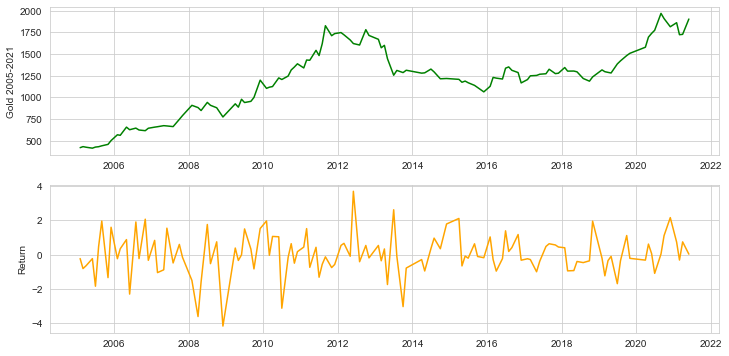

In [8]:
fig, axis = plt.subplots(2, figsize=(12,6))

axis[0].plot(df['Close'], 'green');
axis[0].set_ylabel('Gold 2005-2021');

axis[1].plot(df['Return'], 'orange');
axis[1].set_ylabel('Return');

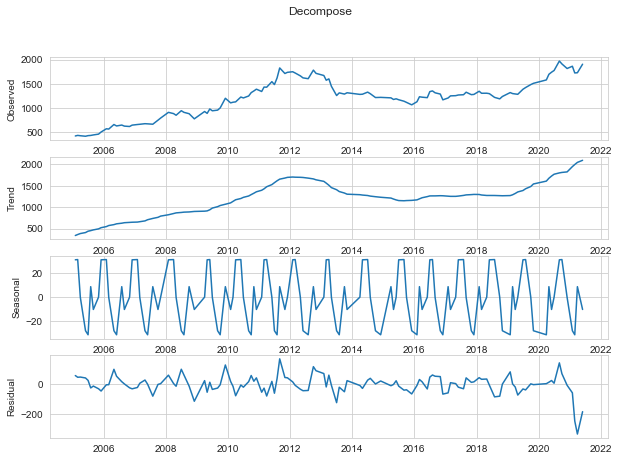

In [9]:
# Set freq 5, 20, 253 Trade day per week month year
res = seasonal_decompose(df['Close'], model="additive", freq=8, extrapolate_trend='freq') 

residual = res.resid
seasonal = res.seasonal
trend = res.trend

fig, axis = plt.subplots(4, figsize=(10,7))
fig.suptitle('Decompose')

axis[0].plot(df['Close'])
axis[0].set_ylabel('Observed')

axis[1].plot(trend)
axis[1].set_ylabel('Trend')

axis[2].plot(seasonal)
axis[2].set_ylabel('Seasonal')

axis[3].plot(residual)
axis[3].set_ylabel('Residual')

plt.show()   

In [523]:
def adf_check(time_series):
    result = adfuller(time_series)
    print('Augmented Dickey-Fuller Test:')
    labels = ['ADF Test Statistic',
              'p-value',
              '#Lags Used',
              'Number of Observations Used']

    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("reject the null hypothesis")
        print("Data has no unit root, and is stationary")
    else:
        print("Weak evidence against null hypothesis")
        print("Fail to reject null hypothesis")
        print("Data has a unit root, it is non-stationary")

In [524]:
df['diff_1'] = diff(df['Close'], k_diff=1)

In [525]:
adf_check(df['Close'].dropna())

Augmented Dickey-Fuller Test:
ADF Test Statistic : -1.1803716298145779
p-value : 0.6819818405817526
#Lags Used : 0
Number of Observations Used : 126
Weak evidence against null hypothesis
Fail to reject null hypothesis
Data has a unit root, it is non-stationary


In [526]:
adf_check(df['diff_1'].dropna())

Augmented Dickey-Fuller Test:
ADF Test Statistic : -11.650655726937694
p-value : 2.041161122355e-21
#Lags Used : 0
Number of Observations Used : 125
Strong evidence against the null hypothesis
reject the null hypothesis
Data has no unit root, and is stationary


In [425]:
len(df)

127

In [367]:
train = df.iloc[:100]
test = df.iloc[100:]

In [435]:
auto_arima(train['Close'], seasonal=True).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  100
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -558.829
Date:                Wed, 30 Jun 2021   AIC                           1119.659
Time:                        01:12:18   BIC                           1122.254
Sample:                             0   HQIC                          1120.709
                                - 100                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      4682.5808    522.490      8.962      0.000    3658.520    5706.642
===================================================================================
Ljung-Box (L1) (Q):                   1.19   Jarque-Bera (JB):                 6.98
Prob(Q):                              0.28   Prob(JB):                         0.03
Heteroskedasticity (H):               1.15   Skew:                             0.33
Prob(H) (two-sided):                  0.70   Kurtosis:                         4.12
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

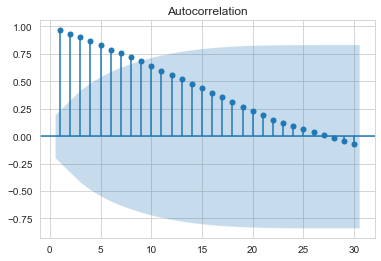

In [491]:
plot_acf(train['Close'], lags=30, zero=False);

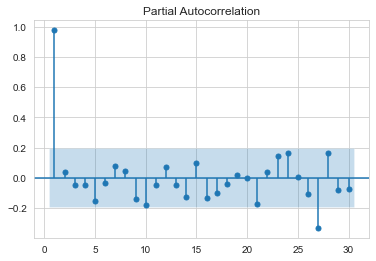

In [492]:
plot_pacf(train['Close'], lags=30, zero=False);

# ARIMA Model

In [436]:
model = ARIMA(train['Close'], order=(0,1,0))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                D.Close   No. Observations:                   99
Model:                 ARIMA(0, 1, 0)   Log Likelihood                -558.038
Method:                           css   S.D. of innovations             67.884
Date:                Wed, 30 Jun 2021   AIC                           1120.075
Time:                        01:12:26   BIC                           1125.266
Sample:                             1   HQIC                          1122.175
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.6192      6.823      1.263      0.206      -4.753      21.991
==============================================================================
"""

In [452]:
s = len(train)
e = len(train) + len(test)-1 
pred = results.predict(start=s, end=e, typ='levels').rename('ARIMA(0,1,0)')

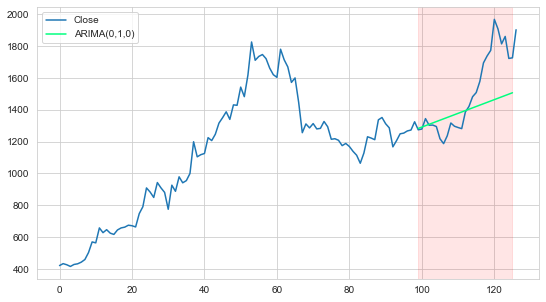

In [487]:
df['Close'].reset_index(drop=True).plot(legend=True, figsize=(9,5));
pred.plot(legend=True, color='springgreen')
plt.axvspan(pred.index[0], pred.index[-1], color='red', alpha=0.1);

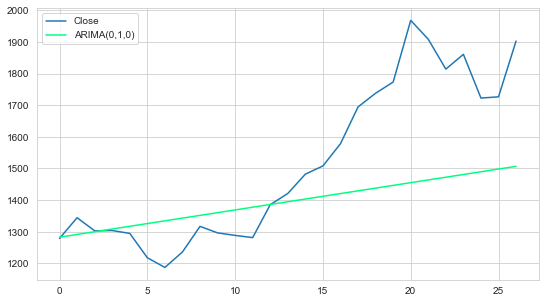

In [454]:
test['Close'].reset_index(drop=True).plot(legend=True, figsize=(9,5));
pred.reset_index(drop=True).plot(legend=True, color='springgreen');

# SARIMAX Model

In [506]:
model = sm.tsa.statespace.SARIMAX(train['Close'], order=(2,1,2), seasonal_order=(1,1,1,12))
res = model.fit()
print(res.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                Close   No. Observations:                  100
Model:             SARIMAX(2, 1, 2)x(1, 1, [1], 12)   Log Likelihood                -499.114
Date:                              Thu, 01 Jul 2021   AIC                           1012.229
Time:                                      18:55:02   BIC                           1029.490
Sample:                                           0   HQIC                          1019.179
                                              - 100                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0442      1.169     -0.038      0.970      -2.336       2.248
ar.L2          0.95

In [507]:
pred_sarima = res.predict(start=s, end=e).rename('SARIMAX')

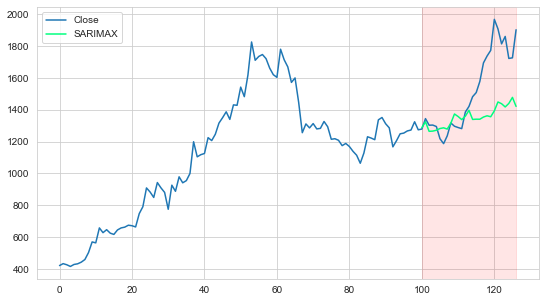

In [508]:
df['Close'].reset_index(drop=True).plot(legend=True, figsize=(9,5));
pred_sarima.plot(legend=True, color='springgreen')
plt.axvspan(pred_sarima.index[0], pred_sarima.index[-1], color='red', alpha=0.1);

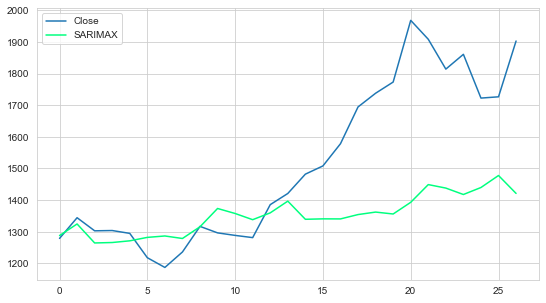

In [509]:
test['Close'].reset_index(drop=True).plot(legend=True, figsize=(9,5));
pred_sarima.reset_index(drop=True).plot(legend=True, color='springgreen');

# Basic ARMA

In [35]:
model_ar_1 = ARMA(df.Return, order=(1,0))
result_ar_1 = model_ar_1.fit()
result_ar_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                 Return   No. Observations:                  127
Model:                     ARMA(1, 0)   Log Likelihood                -201.152
Method:                       css-mle   S.D. of innovations              1.179
Date:                Sun, 04 Jul 2021   AIC                            408.304
Time:                        23:22:29   BIC                            416.837
Sample:                             0   HQIC                           411.771
                                                                              
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0161      0.100      0.160      0.873      -0.181       0.213
ar.L1.Return    -0.0432      0.088     -0.489      0.625      -0.216       0.130
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1          -23.1338           +0.0000j           23.1338            0.5000
-----------------------------------------------------------------------------
"""

In [36]:
model_ar_2 = ARMA(df.Return, order=(2,0))
result_ar_2 = model_ar_2.fit()
result_ar_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                 Return   No. Observations:                  127
Model:                     ARMA(2, 0)   Log Likelihood                -201.134
Method:                       css-mle   S.D. of innovations              1.179
Date:                Sun, 04 Jul 2021   AIC                            410.269
Time:                        23:22:30   BIC                            421.646
Sample:                             0   HQIC                           414.891
                                                                              
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0161      0.099      0.163      0.870      -0.177       0.210
ar.L1.Return    -0.0440      0.088     -0.497      0.619      -0.217       0.129
ar.L2.Return    -0.0166      0.088     -0.188      0.851      -0.190       0.157
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.3211           -7.6377j            7.7511           -0.2773
AR.2           -1.3211           +7.6377j            7.7511            0.2773
-----------------------------------------------------------------------------
"""

# LLR
   - High log likelihood
   - Low info criterion

In [37]:
def LLRtest(mod1, mod2, DF=1):
    L1 = mod1.fit().llf
    L2 = mod2.fit().llf
    LR = 2*(L2-L1)
    p = chi2.sf(LR, DF).round(3)
    return p

In [38]:
LLRtest(model_ar_1, model_ar_2)

0.851

# Using Returns

In [527]:
adf_check(df['Return'])

Augmented Dickey-Fuller Test:
ADF Test Statistic : -11.633656628167973
p-value : 2.231418785662429e-21
#Lags Used : 0
Number of Observations Used : 126
Strong evidence against the null hypothesis
reject the null hypothesis
Data has no unit root, and is stationary


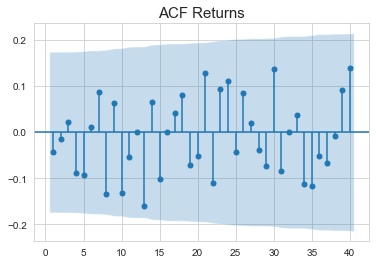

In [538]:
plot_acf(df.Return, lags=40, zero=False);
plt.title('ACF Returns', size=15);

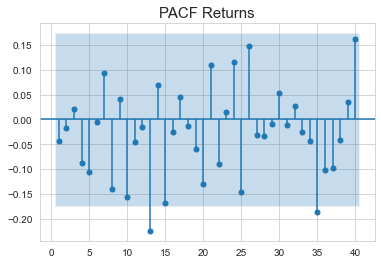

In [539]:
plot_pacf(df.Return, lags=40, zero=False, method=('ols'));
plt.title('PACF Returns', size=15);

In [45]:
ret_ar_5 = ARMA(df.Return, order=(5,0))
result_ret_ar_5 = ret_ar_5.fit()
result_ret_ar_5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                 Return   No. Observations:                  127
Model:                     ARMA(5, 0)   Log Likelihood                -199.941
Method:                       css-mle   S.D. of innovations              1.168
Date:                Mon, 05 Jul 2021   AIC                            413.882
Time:                        01:15:40   BIC                            433.792
Sample:                             0   HQIC                           421.971
                                                                              
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0169      0.083      0.204      0.839      -0.146       0.180
ar.L1.Return    -0.0517      0.088     -0.588      0.557      -0.224       0.121
ar.L2.Return    -0.0177      0.088     -0.202      0.840      -0.190       0.154
ar.L3.Return     0.0134      0.087      0.153      0.879      -0.158       0.185
ar.L4.Return    -0.0921      0.087     -1.056      0.291      -0.263       0.079
ar.L5.Return    -0.1048      0.089     -1.175      0.240      -0.280       0.070
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.1356           -0.9336j            1.4701           -0.1095
AR.2            1.1356           +0.9336j            1.4701            0.1095
AR.3           -0.6707           -1.4107j            1.5621           -0.3206
AR.4           -0.6707           +1.4107j            1.5621            0.3206
AR.5           -1.8088           -0.0000j            1.8088           -0.5000
-----------------------------------------------------------------------------
"""

In [51]:
LLRtest(ret_ar_4, ret_ar_5)

0.242

In [55]:
ret_ma_1 = ARMA(df.Return, order=(0, 1))
result_ret_ma_1 = ret_ma_1.fit()
result_ret_ma_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                 Return   No. Observations:                  127
Model:                     ARMA(0, 1)   Log Likelihood                -201.149
Method:                       css-mle   S.D. of innovations              1.179
Date:                Mon, 05 Jul 2021   AIC                            408.297
Time:                        17:13:16   BIC                            416.830
Sample:                             0   HQIC                           411.764
                                                                              
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0161      0.100      0.161      0.872      -0.180       0.212
ma.L1.Return    -0.0445      0.090     -0.498      0.619      -0.220       0.131
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1           22.4547           +0.0000j           22.4547            0.0000
-----------------------------------------------------------------------------
"""

In [57]:
ret_arma11 = ARMA(df.Return, order=(1, 1))
result_ret_arma11 = ret_arma11.fit()
result_ret_arma11.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                 Return   No. Observations:                  127
Model:                     ARMA(1, 1)   Log Likelihood                -198.715
Method:                       css-mle   S.D. of innovations              1.147
Date:                Mon, 05 Jul 2021   AIC                            405.430
Time:                        17:20:43   BIC                            416.807
Sample:                             0   HQIC                           410.052
                                                                              
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0223      0.021      1.075      0.282      -0.018       0.063
ar.L1.Return     0.8890      0.045     19.661      0.000       0.800       0.978
ma.L1.Return    -1.0000      0.025    -39.364      0.000      -1.050      -0.950
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.1248           +0.0000j            1.1248            0.0000
MA.1            1.0000           +0.0000j            1.0000            0.0000
-----------------------------------------------------------------------------
"""

# ARIMA

In [60]:
arima111 = ARIMA(df.Close, order=(1, 2, 1))
result_arima111 = arima111.fit()
result_arima111.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:               D2.Close   No. Observations:                  125
Model:                 ARIMA(1, 2, 1)   Log Likelihood                -710.226
Method:                       css-mle   S.D. of innovations             70.316
Date:                Mon, 05 Jul 2021   AIC                           1428.452
Time:                        17:59:10   BIC                           1439.766
Sample:                             2   HQIC                          1433.048
                                                                              
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.0509      0.372      0.137      0.891      -0.678       0.780
ar.L1.D2.Close    -0.0936      0.100     -0.933      0.351      -0.290       0.103
ma.L1.D2.Close    -0.9479      0.056    -16.884      0.000      -1.058      -0.838
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1          -10.6813           +0.0000j           10.6813            0.5000
MA.1            1.0550           +0.0000j            1.0550            0.0000
-----------------------------------------------------------------------------
"""

# Exogeneous var

In [73]:
'''start = datetime(2005, 2, 1)
end = datetime(2021, 6, 1)
stock = pdr.get_data_yahoo('SI=F', start=start, end=end)'''

"start = datetime(2005, 2, 1)\nend = datetime(2021, 6, 1)\nstock = pdr.get_data_yahoo('SI=F', start=start, end=end)"

In [107]:
df2 = pd.read_csv('DX-Y.NYB.csv', parse_dates=['Date'], index_col='Date')
df2['Return'] = df2['Close'].pct_change().mul(100)
df2 = df2.asfreq('MS').dropna()

In [108]:
df3 = pd.read_csv('SI=F.csv', parse_dates=['Date'], index_col='Date')
df3['Return'] = df3['Close'].pct_change().mul(100)
df3 = df3.asfreq('MS').dropna()

# ARIMAX

In [77]:
arima111x = ARIMA(df.Return, order=(1, 2, 1), exog=df2.Close)
result_arima111x = arima111x.fit()
result_arima111x.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:               D2.Close   No. Observations:                  125
Model:                 ARIMA(1, 2, 1)   Log Likelihood                -707.538
Method:                       css-mle   S.D. of innovations             68.117
Date:                Mon, 05 Jul 2021   AIC                           1425.076
Time:                        21:11:19   BIC                           1439.217
Sample:                             2   HQIC                          1430.821
                                                                              
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -8.2284      3.412     -2.412      0.016     -14.916      -1.541
Close              0.0955      0.040      2.404      0.016       0.018       0.173
ar.L1.D2.Close    -0.1003      0.091     -1.108      0.268      -0.278       0.077
ma.L1.D2.Close    -1.0000      0.025    -40.750      0.000      -1.048      -0.952
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -9.9733           +0.0000j            9.9733            0.5000
MA.1            1.0000           +0.0000j            1.0000            0.0000
-----------------------------------------------------------------------------
"""

In [111]:
df['ret_DX'] = df2['Return'] 
df['ret_SI'] = df3['Return'] 

In [113]:
train = df[:100]
test = df[100:]

In [114]:
s = len(train)
e = len(train) + len(test) - 1

In [117]:
model_ret_armax = ARIMA(train.Return, exog=train[['ret_DX', 'ret_SI']], order=(1,0,1))
result_ret_armax = model_ret_armax.fit()
result_ret_armax.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                 Return   No. Observations:                  100
Model:                     ARMA(1, 1)   Log Likelihood                -108.022
Method:                       css-mle   S.D. of innovations              0.712
Date:                Tue, 06 Jul 2021   AIC                            228.044
Time:                        01:49:54   BIC                            243.675
Sample:                             0   HQIC                           234.371
                                                                              
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0073      0.073      0.100      0.920      -0.137       0.151
ret_DX          -0.0943      0.148     -0.635      0.525      -0.385       0.197
ret_SI           0.4604      0.041     11.283      0.000       0.380       0.540
ar.L1.Return    -0.8743      0.143     -6.109      0.000      -1.155      -0.594
ma.L1.Return     0.9262      0.116      7.980      0.000       0.699       1.154
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.1438           +0.0000j            1.1438            0.5000
MA.1           -1.0797           +0.0000j            1.0797            0.5000
-----------------------------------------------------------------------------
"""

In [125]:
pred_armax = result_ret_armax.predict(start=s, end=e, exog=test[['ret_DX', 'ret_SI']]).rename('ARMAX')

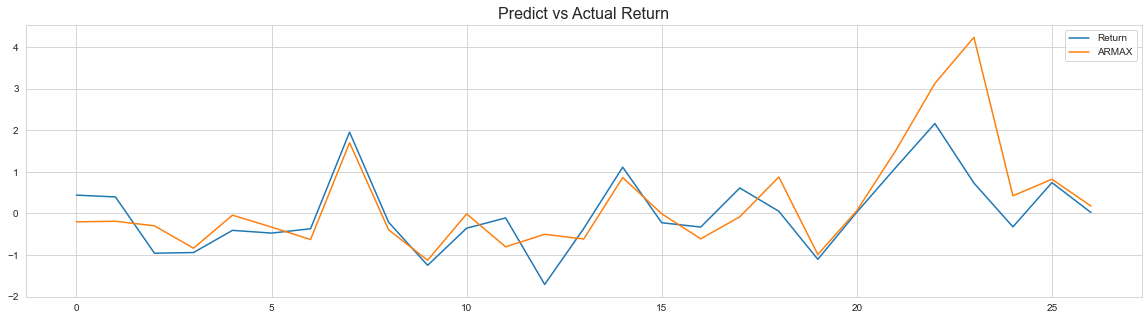

In [130]:
test.Return.reset_index(drop=True).plot(figsize=(20,5), legend=True);
pred_armax.reset_index(drop=True).plot(legend=True);
plt.title('Predict vs Actual Return', size=16);

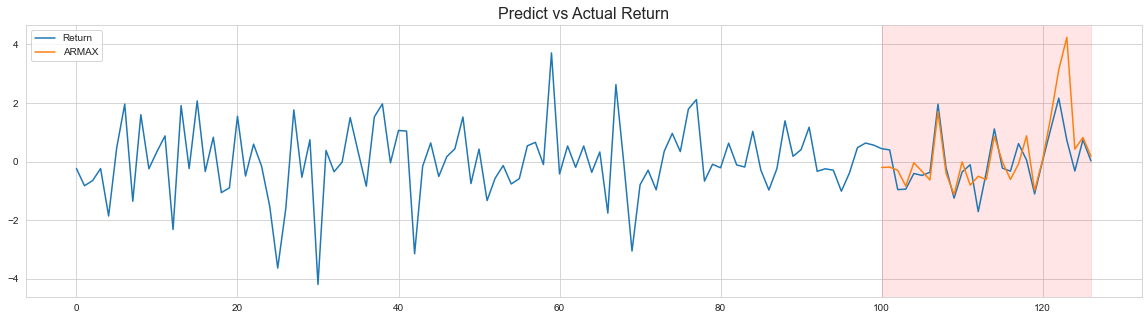

In [133]:
df.Return.reset_index(drop=True).plot(figsize=(20,5), legend=True);
pred_armax.plot(legend=True);
plt.axvspan(pred_armax.index[0], pred_armax.index[-1], color='red', alpha=0.1);
plt.title('Predict vs Actual Return', size=16);

In [134]:
import yfinance

In [136]:
raw_data = yfinance.download(tickers=["GC=F", "SI=F", "^GSPC", "DX-Y.NYB"], start= "2005-02-01", end="2021-06-02",
                 interval="1d", group_by='ticker', auto_adjust=True, treads=True)

[*********************100%***********************]  4 of 4 completed


In [138]:
raw_data['GC=F']

,Open,High,Low,Close,Volume
Date,,,,,
2005-01-31,426.000000,426.500000,419.299988,421.799988,6857.0
2005-02-01,422.200012,422.299988,419.200012,420.799988,1461.0
2005-02-02,420.899994,422.299988,419.799988,421.100006,426.0
2005-02-03,421.299988,421.299988,414.700012,416.600006,574.0
2005-02-04,416.399994,417.799988,413.700012,414.000000,320.0
...,...,...,...,...,...
2021-05-25,1882.500000,1898.099976,1882.500000,1898.099976,56.0
2021-05-26,1901.300049,1901.300049,1901.300049,1901.300049,170526.0
2021-05-27,1896.800049,1903.900024,1888.199951,1895.699951,35794.0
